In [91]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch
from torch.utils.data import TensorDataset
import warnings
warnings.filterwarnings('ignore')

In [41]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import pandas as pd
import seaborn as sns
import torch.nn.functional as F

In [43]:
#train_dataset = MNIST(root='.', train=True, download=True, transform=transform)
#test_dataset = MNIST(root='.', train=False, download=True, transform=transform)

# Define transform to normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std deviation for MNIST
])

# Load MNIST dataset with transformations
train_dataset = MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=False, transform=transform)

In [45]:
# Example: reduce size of datasets
train_size = int(0.1 * len(train_dataset))
test_size = int(0.1 * len(test_dataset))

# Create reduced datasets
train_data_reduced = train_dataset.data[:train_size].float() / 255.0
train_labels_reduced = train_dataset.targets[:train_size].long()

test_data_reduced = test_dataset.data[:test_size].float() / 255.0
test_labels_reduced = test_dataset.targets[:test_size].long()

# Create TensorDataset instances
train_data = TensorDataset(train_data_reduced, train_labels_reduced)
test_data = TensorDataset(test_data_reduced, test_labels_reduced)

print("Type of train_dataset:", type(train_dataset))

Type of train_dataset: <class 'torchvision.datasets.mnist.MNIST'>


In [47]:
#verify attributes
print("Type:", type(train_data))

Type: <class 'torch.utils.data.dataset.TensorDataset'>


In [49]:
print("Train data shape:", train_data_reduced.shape)
print("Train labels shape:", train_labels_reduced.shape)
print("Test data shape:", test_data_reduced.shape)
print("Test labels shape:", test_labels_reduced.shape)

Train data shape: torch.Size([6000, 28, 28])
Train labels shape: torch.Size([6000])
Test data shape: torch.Size([1000, 28, 28])
Test labels shape: torch.Size([1000])


In [51]:
# normalize data to [0 1] from 0 to 255 (max)
#train_dataNorm = train_data / 255.0  # Convert to float and normalize

# Plotting the histograms
#fig, ax = plt.subplots(1, figsize=(10, 4))

#ax.hist(train_data.flatten().numpy(), bins=50)
#ax.set_xlabel('Pixel intensity values')
#ax.set_ylabel('Count')
#ax.set_title('Histogram of normalized data')
#ax.set_yscale('log')  # set to log scale
#convert into data loading format 
##train_data   = torch.tensor(train_dataNorm).float()
##train_labels = torch.tensor(train_labels).long() # long = int64

In [53]:
batch_size = 128

# Create DataLoader instances
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Example: printing lengths of DataLoader batches
print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in test_loader:", len(test_loader))
#translate into dataloader objects
#batchsize    = 32
#train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
#test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

Number of batches in train_loader: 46
Number of batches in test_loader: 1


In [55]:
# check all variables in workspace
#%whos

In [57]:
#create model class instead 
def createmodel():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = x.view(-1, 784)  # Flatten the input 
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      x = F.relu(self.fc2(x))
      x = self.output(x)  # No need for log_softmax here, use NLLLoss directly
      return F.log_softmax(x, dim=1)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=0.1)

  return net,lossfun,optimizer

In [59]:
# test the model with one batch
net,lossfun,optimizer = createmodel()

X,y = next(iter(train_loader)) # get batch of data 
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3095, grad_fn=<NllLossBackward0>)


In [61]:
# a function that trains the model
def trainmodel():

    # number of epochs
    numepochs = 60
    # create a new model
    net, lossfun, optimizer = createmodel()
    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    # loop over epochs
    for epoch in range(numepochs):
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # loss from this batch
            batchLoss.append(loss.item())
            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            accuracy = torch.mean(matches.float()) * 100
            batchAcc.append(accuracy.item())

        # average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # average losses across the batches
        losses[epoch] = np.mean(batchLoss)

        # Evaluate on test data
        test_batch_acc = []
        for X_test, y_test in test_loader:
            yHat_test = net(X_test)
            matches_test = torch.argmax(yHat_test, axis=1) == y_test
            accuracy_test = torch.mean(matches_test.float()) * 100
            test_batch_acc.append(accuracy_test.item())

        # Compute average test accuracy for the epoch
        testAcc.append(np.mean(test_batch_acc))

    # function output
    return trainAcc, testAcc, losses, net


In [63]:
print(yHat.shape)

torch.Size([128, 10])


In [65]:
#print(yHat) #log of probabilities that model is outputting 
#print(torch.exp(yHat)) #convert back to prob
#print(loss) #final check things work 

In [67]:
trainAcc,testAcc,losses,net = trainmodel()

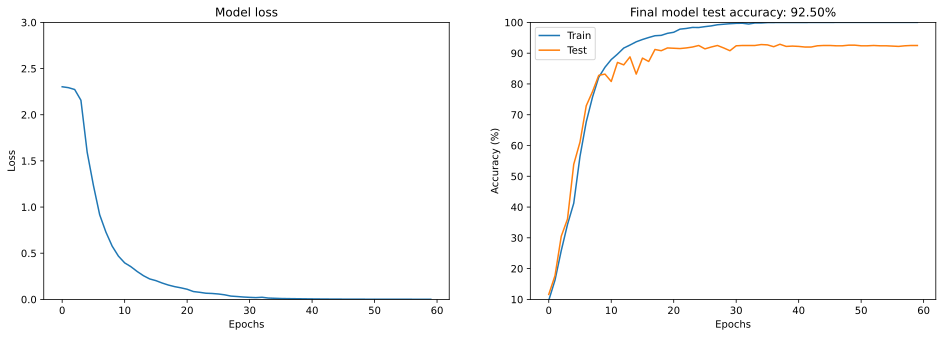

In [69]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [75]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()
predictions;

85


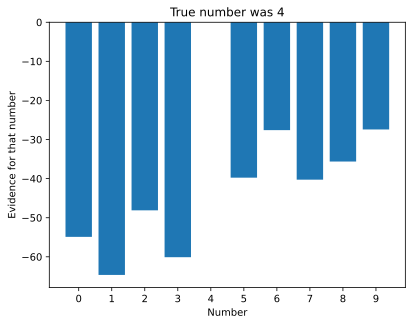

In [82]:
# Evidence for all numbers from one sample
randval = np.random.randint(0, 1001)
sample2show = randval
print(randval)
plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  8  33  44  66 124 126 149 159 233 241 245 247 257 259 268 290 300 313
 318 321 341 352 358 359 381 412 445 448 449 465 478 507 514 528 531 543
 548 582 591 610 613 619 646 659 684 689 691 710 717 720 723 726 738 740
 760 791 804 810 839 844 881 890 898 900 926 930 932 938 939 944 950 951
 956 959 965]
46


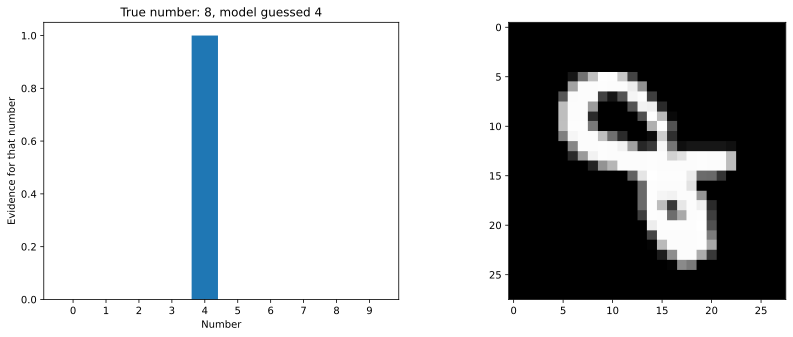

In [89]:
#where is poor performance
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)
randval = np.random.randint(0, 100)
sample2show = randval
print(randval)
# Evidence for all numbers from one sample

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()